In [1]:
# Use py38
# conda create -p /projects/compsci/jgeorge/whitebr/anaconda3/envs/py38 python=3.8
## no! pip install 'spatialtis[all]'
# pip install git+https://github.com/Mr-Milk/SpatialTis.git
import spatialtis as st
import tifffile
import json
import pandas as pd
import numpy as np
from skimage.measure import label, regionprops, regionprops_table
from anndata import AnnData, read_h5ad
# pip install PhenoGraph
# pip install scanpy
import phenograph
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
import os
from sklearn import preprocessing

In [3]:
CODEX_file = '/projects/activities/jaxcc/CATch-project/raw-data/codex/tnbc/mouse/PC24031_B1P804MGT-WP170MGT/raw/phenocycler/PC24031_Scan1.qptiff'
metadata_file = '/projects/activities/jaxcc/CATch-project/raw-data/codex/tnbc/mouse/PC24031_B1P804MGT-WP170MGT/PC24031_metadata.json'
#top_mask_file_orig = '/projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/marker-exhaustive-cd44-cd49f-clip-True-arcsinh-15-normalization-min_max-aggr-meancell_segmentation_PC24031_Scan1_top.tiff'
top_mask_file_orig = '/projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/marker-minimal-cd44-cd49f-clip-True-arcsinh-15-normalization-min_max-aggr-meancell_segmentation_PC24031_Scan1_top.tiff'
# bottom_mask_file_orig = '/projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/marker-exhaustive-cd44-cd49f-clip-True-arcsinh-15-normalization-min_max-aggr-meancell_segmentation_PC24031_Scan1_bottom.tiff'
bottom_mask_file_orig = top_mask_file_orig.replace('top', 'bottom')
anndata_top_output_file = top_mask_file_orig.replace('.tiff', '-adata.h5ad')
anndata_bottom_output_file = bottom_mask_file_orig.replace('.tiff', '-adata.h5ad')
heatmap_top_all_output_file = top_mask_file_orig.replace('.tiff', '-heatmap-all.png')
heatmap_top_output_file = top_mask_file_orig.replace('.tiff', '-heatmap.png')
heatmap_bottom_all_output_file = bottom_mask_file_orig.replace('.tiff', '-heatmap-all.png')
heatmap_bottom_output_file = bottom_mask_file_orig.replace('.tiff', '-heatmap.png')

In [12]:
heatmap_top_output_file

'/projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/marker-minimal-cd44-cd49f-clip-True-arcsinh-15-normalization-min_max-aggr-meancell_segmentation_PC24031_Scan1_top-heatmap.png'

In [13]:
# from spatialtis
def parse_img(stacked_img, img_axes: str = "cyx"):
    try:
        from tifffile import TiffFile
        from skimage.io import imread
    except ImportError:
        raise ImportError("Required scikit-image, try `pip install scikit-image`.")

    stacked_img = str(stacked_img)
    imread_status = True

    try:
        img_data = imread(stacked_img)
        if img_axes == "cyx":
            return img_data.transpose((1, 2, 0))
        return img_data

    except Exception:
        msg = f"Faild to parse {stacked_img}, it should stored as XYC, try to read from page to page"
        warnings.warn(msg)
        imread_status = False

    img_data = []
    if not imread_status:
        with TiffFile(stacked_img) as tif:
            for p in tif.pages:
                img_data.append(p.asarray())

    # TODO: 3d support?
    img_data = np.array(img_data)
    if img_data.ndim > 4:
        raise ValueError("The dimensions of image are too much")
    else:
        return img_data.transpose((1, 2, 0))

In [14]:
# Simplified version of spatialtis read_images
# /projects/compsci/jgeorge/whitebr/anaconda3/envs/py38/lib/python3.8/site-packages/spatialtis/preprocessing/read_images.py
def measurements_to_anndata(measurements, markers):
    intensity_measure = 'mean'
    exp_all = []
    for v in measurements['image_intensity']:
        cell_exp = getattr(v, intensity_measure).__call__(axis=(0, 1))
        exp_all.append(cell_exp)
        
    meta = pd.DataFrame({
            "label": measurements['label'],
            "centroid_x": measurements['centroid-0'],
            "centroid_y": measurements['centroid-1'],
        })

    points = [list(d.values) for _, d in meta[
        ['centroid_x', 'centroid_y']].iterrows()]

    meta['area'] = measurements['area']
    meta['major_axis'] = measurements['axis_major_length']
    meta['minor_axis'] = measurements['axis_minor_length']
    meta['eccentricity'] = measurements['eccentricity']
    meta['extent'] = measurements['extent']
    meta['orientation'] = measurements['orientation']

    obs = meta.reset_index(drop=True)
    X = np.array(exp_all)

    adata = AnnData(obs=obs, var=markers, X=X)

    centroid_cols = ['centroid_x', 'centroid_y']
    adata.obsm['spatial'] = adata.obs[centroid_cols].to_numpy()

    return(adata)

In [15]:
# Taken from here:
# https://github.com/scverse/scanpy/issues/181
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [16]:
# https://stackoverflow.com/questions/49582178/add-1-histogram-to-side-of-clustermap
# plot clustermap

def clustermap_with_marginal_histogram(mat_z, counts_df, title, plot_output_file):

    cluster = sns.clustermap(mat_z, cmap="Blues")
    cluster.fig.suptitle(title)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_xticklabels())]
    ind = np.array([list(counts_df.cluster.values).index(int(t)) for t in target])
    #print(counts_df.cluster.values[ind])
    #print([x for x in range(0,len(counts_df))])
    #enlarge figure
    cluster.fig.set_size_inches(9,9)
    # make some space to the right in the figure
    #cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_row_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("bottom", size="20%", pad=0.1)
    # create empty space of same size as bar plot axes (don't use this space)
    # nax = divider2.new_vertical(size="20%", pad=1.7)
    nax = divider2.append_axes("bottom", size="20%", pad=0.1)

    # plot bar plot in ax
    ax.bar(np.arange(len(target)), counts_df['size'].values[ind])
    ax.set_xticklabels([])
    #ax.set_xticks(range(1,len(counts_df)+1), [str(cls) for cls in counts_df.cluster.values[ind]])
    ax.set_xticks([x for x in range(0,len(target))], [str(cls) for cls in counts_df.cluster.values[ind]])
    # ax.set_xticks([x for x in np.arange(-0.5,len(df.index)-.5, 1)], [str(cls) for cls in counts_df.cluster.values[ind]])
    ax.set_ylabel("Cluster size")
    ax.set_xlabel("Cluster")
    #print(counts_df.cluster.values[ind])
    #nax.set_xticklabels([])
    #nax.set_xticks([x for x in range(0,len(counts_df))], [str(cls) for cls in counts_df.cluster.values[ind]])
    nax.set_yticklabels([])
    # nax.set_xticks([])
    nax.set_yticks([])
    nax.set_axis_off()

    ax.set_xlim(-0.5,len(counts_df.index)-.5)
    #cluster.fig.suptitle(title)
        
    #ax.invert_yaxis()
    # plt.show()
    cluster.figure.tight_layout()
    plt.savefig(plot_output_file)

In [17]:
with open(metadata_file, "r") as file:
    data = json.load(file)
if isinstance(data, list):
    data=data[0]
channel_names_ = [data["channels"][channel]["Biomarker"] for channel in data["channels"]]

markers = pd.DataFrame(index=channel_names_)
print(markers)

Empty DataFrame
Columns: []
Index: [DAPI, Granzyme B, Ly-6C, F4/80, PDCA-1, PD-L1, FOXP3, Vimentin, Nkp46, XCR1, CD163, GL7, iNOS, CD31, CD90.2, CD11c, CD44, CD45, TCRb, MHC II, CD45R/B220, CD3, CD19, IgM, CD49f, CD4, CD24, PD-1, CD8a, CD11b, CD169, Ki67, Pan-Cytokeratin, CD21/35, Ter119, IgD]


In [18]:
top_mask = tifffile.imread(top_mask_file_orig)
bottom_mask = tifffile.imread(bottom_mask_file_orig)

In [19]:
top_mask = np.squeeze(top_mask)
bottom_mask = np.squeeze(bottom_mask)

In [20]:
top_mx = top_mask.max()
print(top_mx)
bottom_mx = bottom_mask.max()
print(bottom_mx)

504009
497268


In [21]:
bottom_mask[bottom_mask != 0] += top_mx
print(bottom_mask.max())
print(top_mx + bottom_mx)

1001277
1001277


In [22]:
mask = np.concatenate([top_mask, bottom_mask],axis=0)

In [23]:
print(top_mask.shape)
print(bottom_mask.shape)
print(mask.shape)

(24120, 24960)
(24120, 24960)
(48240, 24960)


In [24]:
image_axes = "cyx"
# from spatialtis.preprocessing.read_images import parse_img
intensities = parse_img(Path(CODEX_file), img_axes=image_axes)

In [25]:
properties = ['label', 'centroid', 'image_intensity',
                  'area', 'eccentricity', 'coords', 'extent',
                  'orientation', 'axis_major_length', 'axis_minor_length'
                  ]

In [26]:
measurements_tbl = regionprops_table(np.squeeze(mask), intensities, properties=properties)

In [27]:
adata = measurements_to_anndata(measurements_tbl, markers)

/projects/compsci/jgeorge/whitebr/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [28]:
# Separate the anndata into that corresponding to the top and bottom images
adata_top = adata[adata.obs["label"] <= top_mx, :]
adata_bottom = adata[adata.obs["label"] > top_mx, :]

In [29]:
print('Writing ' + anndata_top_output_file + '\n')
adata_top.write_h5ad(anndata_top_output_file, compression='gzip')
print('Writing ' + anndata_bottom_output_file + '\n')
adata_bottom.write_h5ad(anndata_bottom_output_file, compression='gzip')

Writing /projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/marker-minimal-cd44-cd49f-clip-True-arcsinh-15-normalization-min_max-aggr-meancell_segmentation_PC24031_Scan1_top-adata.h5ad

Writing /projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/marker-minimal-cd44-cd49f-clip-True-arcsinh-15-normalization-min_max-aggr-meancell_segmentation_PC24031_Scan1_bottom-adata.h5ad



In [30]:
print('Running phenograph on top\n')
k = 30 # choose k
top_communities, top_graph, top_Q = phenograph.cluster(pd.DataFrame(adata_top.X),k=k) # run PhenoGraph

Running phenograph on top

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 115.08764457702637 seconds
Jaccard graph constructed in 246.51208782196045 seconds
Wrote graph to binary file in 8.349486112594604 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.840401
After 6 runs, maximum modularity is Q = 0.84166
After 8 runs, maximum modularity is Q = 0.842859
After 11 runs, maximum modularity is Q = 0.844462
Louvain completed 25 runs in 2027.2514157295227 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 2494.1206109523773 seconds


In [31]:
adata_top.obs['PhenoGraph_clusters'] = pd.Categorical(top_communities)
adata_top.uns['PhenoGraph_Q'] = top_Q
adata_top.uns['PhenoGraph_k'] = k

/tmp/ipykernel_32501/4237805392.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_top.obs['PhenoGraph_clusters'] = pd.Categorical(top_communities)


In [32]:
print('Writing ' + anndata_top_output_file + ' after phenograph\n')
adata_top.write_h5ad(anndata_top_output_file, compression='gzip')

Writing /projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/marker-minimal-cd44-cd49f-clip-True-arcsinh-15-normalization-min_max-aggr-meancell_segmentation_PC24031_Scan1_top-adata.h5ad after phenograph



In [ ]:
print('Running phenograph on bottom\n')
k = 30 # choose k
bottom_communities, bottom_graph, bottom_Q = phenograph.cluster(pd.DataFrame(adata_bottom.X),k=k) # run PhenoGraph

Running phenograph on bottom

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 110.85338830947876 seconds
Jaccard graph constructed in 236.30726385116577 seconds
Wrote graph to binary file in 8.666516542434692 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.79832
After 6 runs, maximum modularity is Q = 0.800961
Louvain completed 26 runs in 1296.1921133995056 seconds
Sorting communities by size, please wait ...


In [ ]:
adata_bottom.obs['PhenoGraph_clusters'] = pd.Categorical(bottom_communities)
adata_bottom.uns['PhenoGraph_Q'] = bottom_Q
adata_bottom.uns['PhenoGraph_k'] = k

In [ ]:
print('Writing ' + anndata_bottom_output_file + ' after phenograph\n')
adata_bottom.write_h5ad(anndata_bottom_output_file, compression='gzip')

In [33]:
mat = grouped_obs_mean(adata_top, group_key='PhenoGraph_clusters')
mat_z = np.transpose(scipy.stats.zscore(np.transpose(mat)))
df = pd.DataFrame.from_dict(Counter(top_communities), orient='index').reset_index()
df = df.rename(columns={'index':'cluster', 0:'size'})
counts_df = df

In [34]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(np.transpose(mat))
mat_mm = pd.DataFrame(np.transpose(d), columns=mat.columns, index=mat.index)

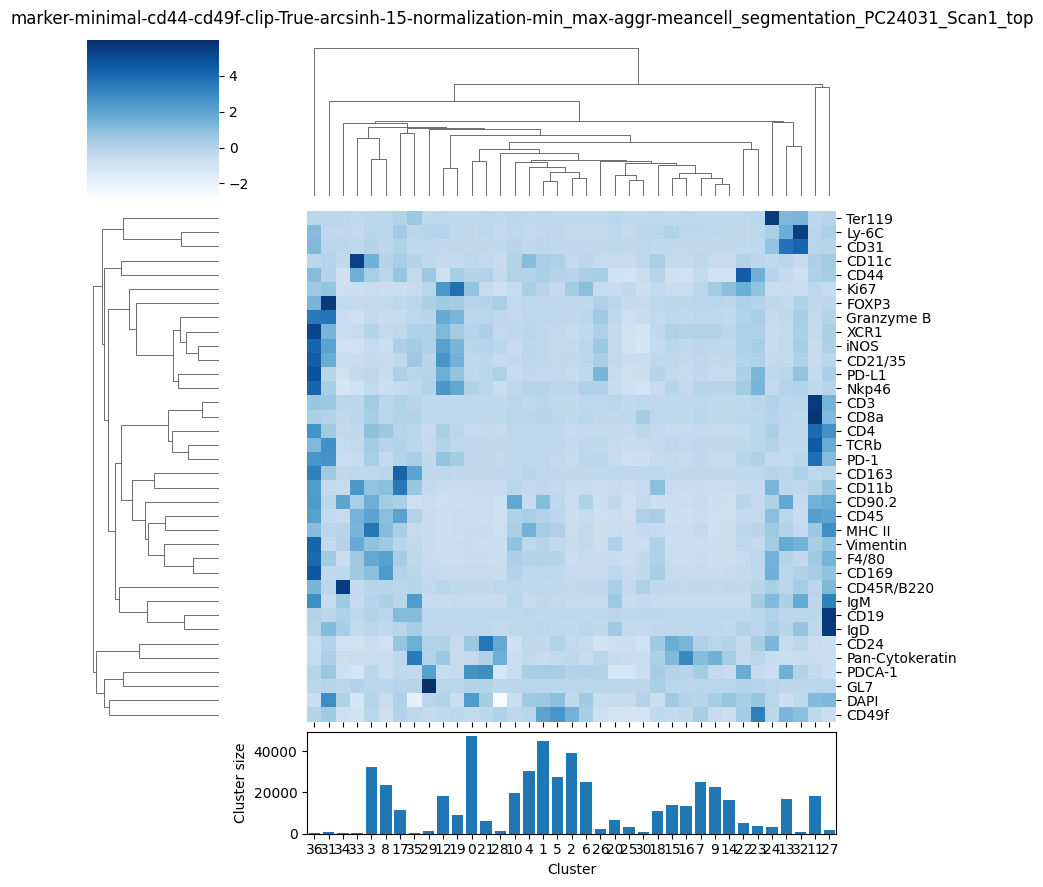

In [35]:
clustermap_with_marginal_histogram(mat_z, counts_df, os.path.basename(top_mask_file_orig).replace(".tiff",""), heatmap_top_all_output_file)

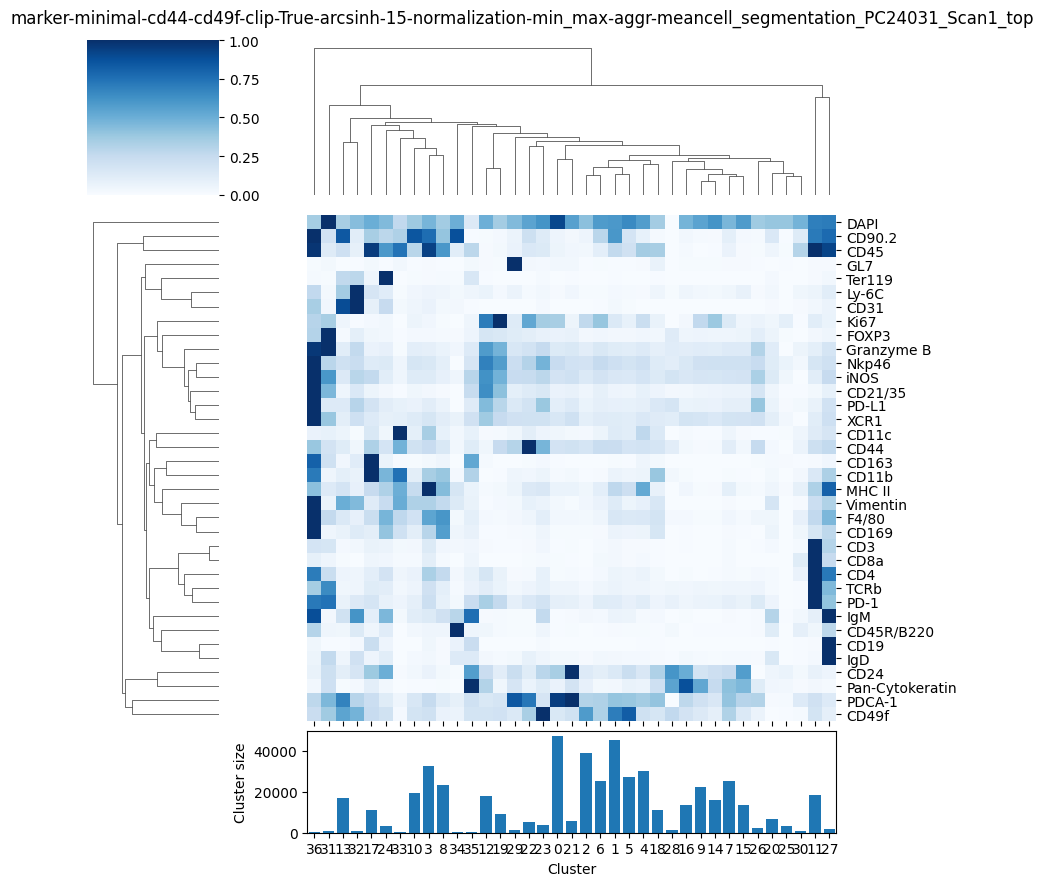

In [36]:
clustermap_with_marginal_histogram(mat_mm, counts_df, os.path.basename(top_mask_file_orig).replace(".tiff",""), heatmap_top_all_output_file.replace(".png", "-minmax.png"))

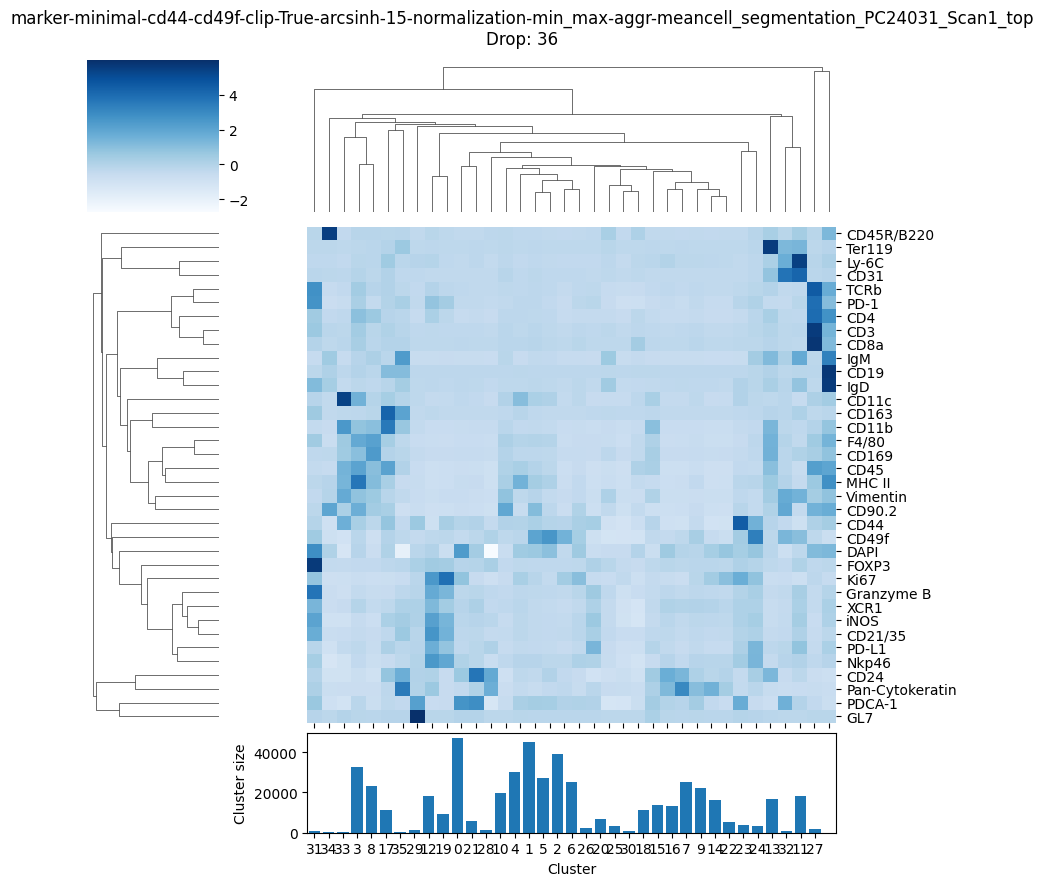

In [37]:
col_to_drop = mat_z.sum(axis=0).argmax()
title = os.path.basename(top_mask_file_orig).replace(".tiff","") + '\nDrop: ' + str(col_to_drop)
clustermap_with_marginal_histogram(mat_z.drop(axis = 'columns', columns = col_to_drop), counts_df, title, heatmap_top_output_file)

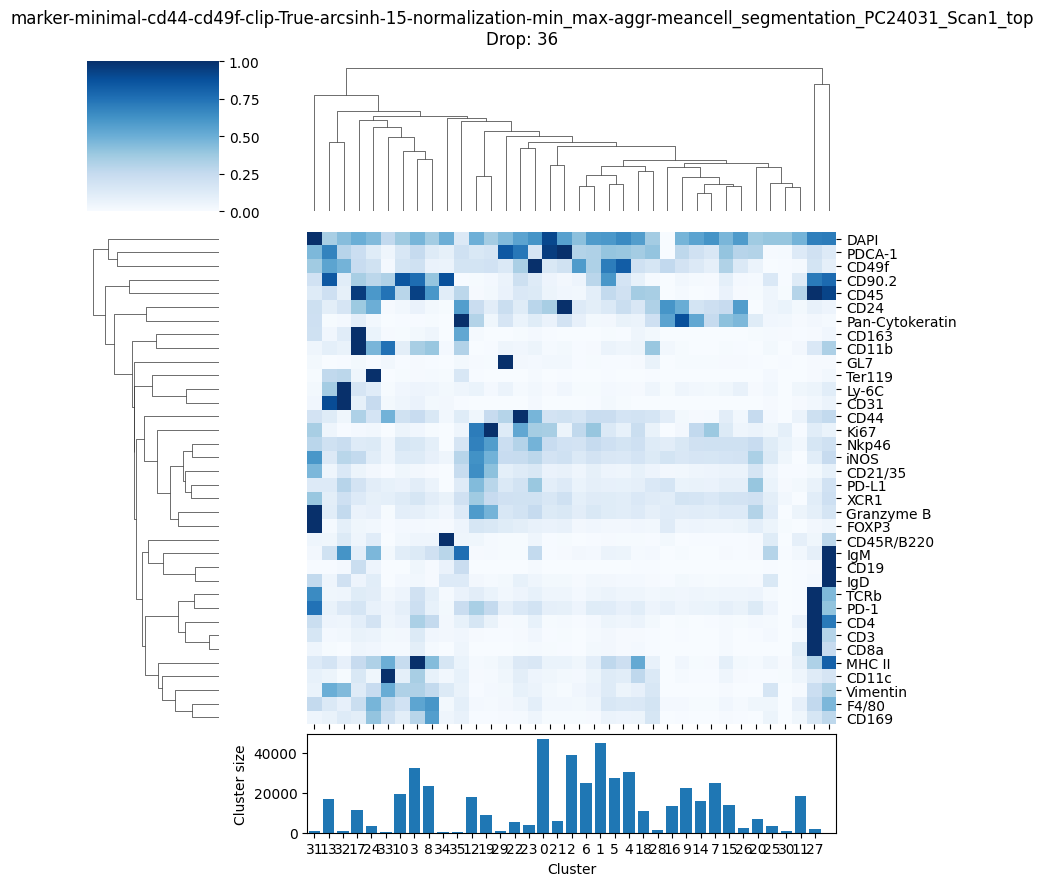

In [38]:
clustermap_with_marginal_histogram(mat_mm.drop(axis = 'columns', columns = col_to_drop), counts_df, title, heatmap_top_output_file.replace(".png", "-minmax.png"))

In [ ]:
mat = grouped_obs_mean(adata_bottom, group_key='PhenoGraph_clusters')
mat_z = np.transpose(scipy.stats.zscore(np.transpose(mat)))
df = pd.DataFrame.from_dict(Counter(bottom_communities), orient='index').reset_index()
df = df.rename(columns={'index':'cluster', 0:'size'})
counts_df = df
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(np.transpose(mat))
mat_mm = pd.DataFrame(np.transpose(d), columns=mat.columns, index=mat.index)

In [ ]:
clustermap_with_marginal_histogram(mat_z, counts_df, os.path.basename(bottom_mask_file_orig).replace(".tiff",""), heatmap_bottom_all_output_file)

In [ ]:
clustermap_with_marginal_histogram(mat_mm, counts_df, os.path.basename(bottom_mask_file_orig).replace(".tiff",""), heatmap_bottom_all_output_file.replace(".png", "-minmax.png"))

In [ ]:
col_to_drop = mat_z.sum(axis=0).argmax()
title = os.path.basename(bottom_mask_file_orig).replace(".tiff","") + '\nDrop: ' + str(col_to_drop)
clustermap_with_marginal_histogram(mat_z.drop(axis = 'columns', columns = col_to_drop), counts_df, title, heatmap_bottom_output_file)

In [ ]:
clustermap_with_marginal_histogram(mat_mm.drop(axis = 'columns', columns = col_to_drop), counts_df, title, heatmap_bottom_output_file.replace(".png", "-minmax.png"))

In [ ]:
print('Done!')

In [ ]:
g = sns.jointplot(data=df, x='day', y='hour', kind='hist', bins=(D, H))
g.ax_marg_y.cla()
g.ax_marg_x.cla()
sns.heatmap(data=df['Cost Dif.'].to_numpy().reshape(D, H).T, ax=g.ax_joint, cbar=False, cmap='Blues')

g.ax_marg_y.barh(np.arange(0.5, H), df.groupby(['hour'])['Cost Dif.'].sum().to_numpy(), color='navy')
g.ax_marg_x.bar(np.arange(0.5, D), df.groupby(['day'])['Cost Dif.'].sum().to_numpy(), color='navy')

g.ax_joint.set_xticks(np.arange(0.5, D))
g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
g.ax_joint.set_yticks(np.arange(0.5, H))
g.ax_joint.set_yticklabels(range(H), rotation=0)

# remove ticks between heatmao and histograms
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# remove ticks showing the heights of the histograms
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
# g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
plt.show()

(array([44853., 42994., 35536., 34684., 30687., 30593., 25510., 24694.,
        23662., 21390., 20632., 18566., 18365., 16188., 14958., 14558.,
        14452., 14326.,  9977.,  8658.,  8645.,  5202.,  4164.,  4002.,
         2888.,  2737.,  2645.,  2368.,  1733.,  1721.,  1006.,   712.,
          330.]),
 array([ 0.        ,  0.96969697,  1.93939394,  2.90909091,  3.87878788,
         4.84848485,  5.81818182,  6.78787879,  7.75757576,  8.72727273,
         9.6969697 , 10.66666667, 11.63636364, 12.60606061, 13.57575758,
        14.54545455, 15.51515152, 16.48484848, 17.45454545, 18.42424242,
        19.39393939, 20.36363636, 21.33333333, 22.3030303 , 23.27272727,
        24.24242424, 25.21212121, 26.18181818, 27.15151515, 28.12121212,
        29.09090909, 30.06060606, 31.03030303, 32.        ]),
 <BarContainer object of 33 artists>)

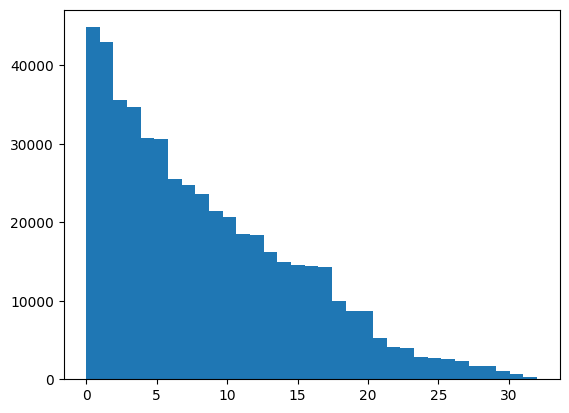

In [79]:
plt.hist(communities, bins=len(np.unique(communities)))

In [ ]:
# stop!

In [10]:
mask_file = top_mask_file_orig.replace("_top.tiff", "_squeezed.tiff")
print(mask_file)

/projects/activities/jaxcc/CATch-project/analysis/whitebr/tnbc/mouse/PC24031/cell_segmentation_processed_squeezed.tiff


In [11]:
tifffile.imwrite(mask_file, mask)

In [12]:
image_expression = tifffile.imread(CODEX_file)

In [18]:
image_expression[1,:,:].max()

255

In [27]:
mat = image_expression.copy()

In [28]:
mat.shape

(36, 48240, 24960)

In [24]:
mat.max()

255

In [25]:
mat2 = np.clip(mat, 0, np.percentile(mat,99))

In [26]:
mat2.max()

54.0

In [20]:
np.percentile(image_expression[1,:,:],99)

54.0

In [ ]:
def my_func(a):
    np.clip(a, 0, np.percentile(a, 99))
im = np.apply_along_axis(my_func, axis=0, arr=image_expression)

In [ ]:
#gain(image_expression[channel_names_.index('CD45'),:,:].flatten(),
#     image_expression[channel_names_.index('CD3'),:,:].flatten())

In [14]:
image_expression.shape

(36, 48240, 24960)

In [15]:
with open(metadata_file, "r") as file:
    data = json.load(file)
if isinstance(data, list):
    data=data[0]
channel_names_ = [data["channels"][channel]["Biomarker"] for channel in data["channels"]]

In [16]:
markers = pd.DataFrame(index=channel_names_)

# Define the metadata for each of the contained images
annotations = pd.DataFrame({
    "ROI": ["Upper"]})

images = [CODEX_file]
masks = [mask_file]

In [19]:
intensities.shape

(48240, 24960, 36)

In [20]:
msk_data = tifffile.imread(mask_file)

In [21]:
np.squeeze(msk_data).shape

(48240, 24960)

In [22]:
label_image = np.squeeze(msk_data)
ndim = label_image.ndim
ndim

2

In [23]:
intensity_image = intensities
print(intensity_image.shape[:ndim])
print(label_image.shape)

(48240, 24960)
(48240, 24960)


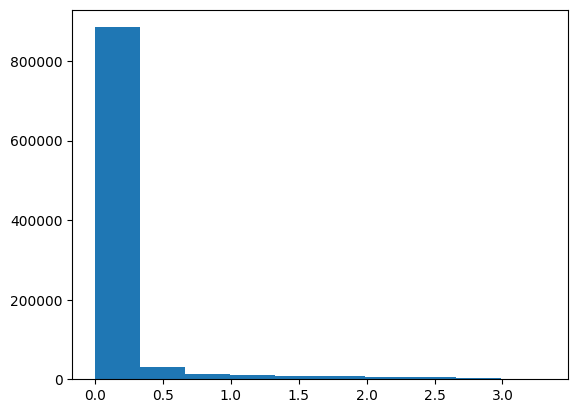

In [126]:
plt.hist(np.arcsinh(cd3/15));
#plt.hist(cd45);


In [122]:
from sklearn.metrics import mutual_info_score
print(mutual_info_score(cd3,cd45))
print(mutual_info_score(cd45,cd3))


/projects/compsci/jgeorge/whitebr/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


8.528701372706566


/projects/compsci/jgeorge/whitebr/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


8.528701372706564


In [123]:


##Entropy
def entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en


#Joint Entropy
def jEntropy(Y,X):
    """
    H(Y;X)
    Reference: https://en.wikipedia.org/wiki/Joint_entropy
    """
    YX = np.c_[Y,X]
    return entropy(YX)

#Conditional Entropy
def cEntropy(Y, X):
    """
    conditional entropy = Joint Entropy - Entropy of X
    H(Y|X) = H(Y;X) - H(X)
    Reference: https://en.wikipedia.org/wiki/Conditional_entropy
    """
    return jEntropy(Y, X) - entropy(X)


#Information Gain
def gain(Y, X):
    """
    Information Gain, I(Y;X) = H(Y) - H(Y|X)
    Reference: https://en.wikipedia.org/wiki/Information_gain_in_decision_trees#Formal_definition
    """
    return entropy(Y) - cEntropy(Y,X)


In [127]:
print(gain(cd3,cd45))
print(gain(cd45,cd3))
cd3

12.304315175626634
12.304315175626652


array([0.        , 0.07      , 0.17571429, ..., 0.        , 0.        ,
       0.50850662])

In [95]:
mat = image_expression[1:5,12000:12100,12000:12100]
print(mat.shape)
print(mat)
np.max(mat,axis=0)

(4, 100, 100)
[[[10 10 13 ... 11 13 14]
  [ 8  9  9 ... 12 12 12]
  [ 6  7  9 ... 12 14 15]
  ...
  [ 5  5  4 ...  6  6  5]
  [ 6  5  3 ...  5  6  7]
  [ 5  5  6 ...  5  5  5]]

 [[ 2  0  4 ...  0  0  0]
  [ 0  0  4 ...  0  0  0]
  [ 0  1  8 ...  1  1  1]
  ...
  [ 0  0  0 ...  1  2  0]
  [ 1  0  0 ...  0  1  0]
  [ 0  0  0 ...  0  0  0]]

 [[19 15 17 ...  3  4  6]
  [16 17 17 ...  3  3  4]
  [14 13 11 ...  4  5  3]
  ...
  [ 3  1  2 ...  4  5  4]
  [ 5  3  1 ...  2  4  3]
  [ 5  3  3 ...  2  3  2]]

 [[ 8  8  4 ...  3  2  9]
  [ 6  4  4 ...  0  2  6]
  [ 5  4  5 ...  2  5  9]
  ...
  [ 8  3  1 ...  4  5  6]
  [12  6  3 ...  4 11 10]
  [13  6  3 ...  5  9  9]]]


array([[19, 15, 17, ..., 11, 13, 14],
       [16, 17, 17, ..., 12, 12, 12],
       [14, 13, 11, ..., 12, 14, 15],
       ...,
       [ 8,  5,  4, ...,  6,  6,  6],
       [12,  6,  3, ...,  5, 11, 10],
       [13,  6,  6, ...,  5,  9,  9]], dtype=uint8)

In [25]:
# measurements = regionprops(np.squeeze(msk_data), intensities)

In [29]:
measurements_tbl = regionprops_table(np.squeeze(msk_data), intensities, properties=properties)

In [33]:
measurements = measurements_tbl
intensity_measure = 'mean'
exp_all = []
for v in measurements['image_intensity']:
    cell_exp = getattr(v, intensity_measure).__call__(axis=(0, 1))
    exp_all.append(cell_exp)


In [38]:
meta = pd.DataFrame({
            "label": measurements['label'],
            "centroid_x": measurements['centroid-0'],
            "centroid_y": measurements['centroid-1'],
        })

points = [list(d.values) for _, d in meta[
    ['centroid_x', 'centroid_y']].iterrows()]

meta['area'] = measurements['area']
meta['major_axis'] = measurements['axis_major_length']
meta['minor_axis'] = measurements['axis_minor_length']
meta['eccentricity'] = measurements['eccentricity']
meta['extent'] = measurements['extent']
meta['orientation'] = measurements['orientation']

obs = meta.reset_index(drop=True)
X = np.array(exp_all)

adata = AnnData(obs=obs, var=markers, X=X)

centroid_cols = ['centroid_x', 'centroid_y']
adata.obsm['spatial'] = adata.obs[centroid_cols].to_numpy()

In [64]:

adata[:, "CD45"].X.toarray()

array([[0.00000000e+00],
       [5.18900000e+01],
       [2.02000000e+00],
       ...,
       [2.50391236e-03],
       [2.17391304e-03],
       [6.16257089e-01]])

In [75]:
cd3 = np.squeeze(adata[:,"CD3"].X.toarray())
cd45 = np.squeeze(adata[:,"CD45"].X.toarray())

Matplotlib is building the font cache; this may take a moment.


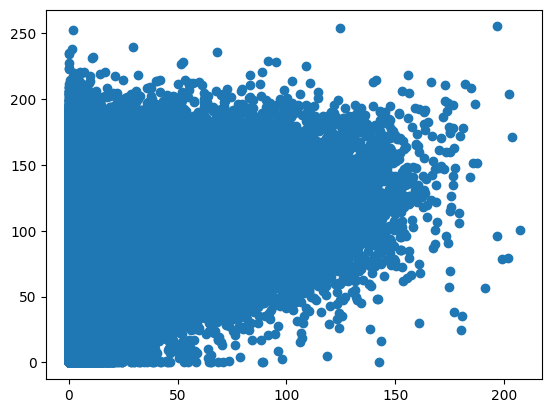

In [76]:
import matplotlib.pyplot as plt
plt.scatter(cd3,cd45)

In [78]:
print(cd3.shape)
print(cd3[cd3>0].shape)

(970056,)
(917662,)


(array([4.56122e+05, 2.53522e+05, 1.37159e+05, 6.64280e+04, 3.40070e+04,
        1.57770e+04, 5.73100e+03, 1.19900e+03, 1.01000e+02, 1.00000e+01]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

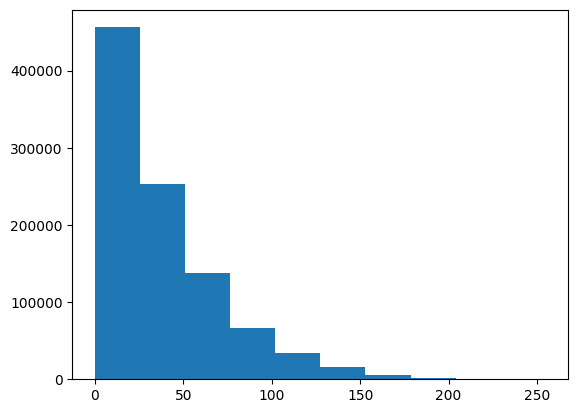

In [80]:
plt.hist(cd45)

<Axes: >

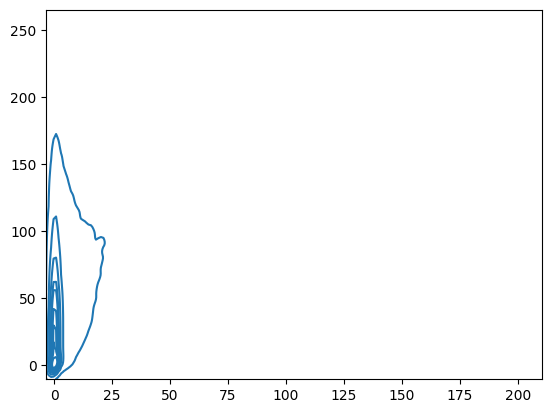

In [83]:
import seaborn as sns
sns.kdeplot(x=cd3,y=cd45)

In [129]:
# measurements = regionprops_table(np.squeeze(msk_data), intensities)

In [62]:
# ?st.read_images

In [ ]:
# Create the AnnData object using the spatialtis-core package's read_images function
adata_img = st.read_images(images, masks, markers=markers, annotations=annotations)

In [44]:

?regionprops

Signature:
regionprops(
    label_image,
    intensity_image=None,
    cache=True,
    *,
    extra_properties=None,
    spacing=None,
    offset=None,
)
Docstring:
Measure properties of labeled image regions.

Parameters
----------
label_image : (M, N[, P]) ndarray
    Labeled input image. Labels with value 0 are ignored.

    .. versionchanged:: 0.14.1
        Previously, ``label_image`` was processed by ``numpy.squeeze`` and
        so any number of singleton dimensions was allowed. This resulted in
        inconsistent handling of images with singleton dimensions. To
        recover the old behaviour, use
        ``regionprops(np.squeeze(label_image), ...)``.
intensity_image : (M, N[, P][, C]) ndarray, optional
    Intensity (i.e., input) image with same size as labeled image, plus
    optionally an extra dimension for multichannel data. Currently,
    this extra channel dimension, if present, must be the last axis.
    Default is None.

    .. versionchanged:: 0.18.0
        The a

In [ ]:
# Specify the path for the high-dimensional image in the temporary directory
    temp_img_dir=temp_dir+'/raw_img_io/myimgs44.tiff'
    
    # Write the high-dimensional data to the specified path
    tifffile.imwrite(temp_img_dir, data)
    
    # Add the image path to the images list
    images.append(temp_img_dir)
    
    # Specify the path for the mask in the temporary directory
    temp_mask_dir=temp_dir+'/masks/myimgs44.tiff'
    
    # Write the cell segmentation mask data to the specified path
    tifffile.imwrite(temp_mask_dir, np.squeeze(image_mask, axis=None))
    
    # Add the cell segmentation mask path to the masks list
    masks.append(temp_mask_dir)

# Here, we do employ the channel names vairable which contains the marker names to annotate each AnnData object column
markers = pd.DataFrame(index=channel_names_)

# Define the metadata for each of the contained images
annotations = pd.DataFrame({
    "ROI": ["Upper"]})

# Create the AnnData object using the spatialtis-core package's read_images function
adata_img = st.read_images(images, masks, markers=markers, annotations=annotations)

# Assign channel names to the 'markers' column of the AnnData's var attribute
adata_img.var['markers']=channel_names_
adata=adata_img
adata